## Toeplitz Example

[Run in Colab](https://colab.research.google.com/github/mmuckley/torchkbnufft/blob/main/notebooks/Toeplitz%20Example.ipynb)

Here we demonstrate an application of Toeplitz embedding with `torchkbnufft`. For a NUFFT matrix F, the operation F'F is block Toeplitz with Toeplitz blocks. Such a matrix can be embedded into a circulant matrix, which allows its evaluation with only FFTs (i.e., no interpolations) at very high speeds. TorchKbNufft includes utilities for estimating the frequency response for the filter, as well as a convenience function for applying the filter.

### Reference

Feichtinger, H. G., Gr, K., & Strohmer, T. (1995). Efficient numerical methods in non-uniform sampling theory. Numerische Mathematik, 69(4), 423-440.

In [ ]:
!pip install torchkbnufft matplotlib numpy torch scikit-image
!git clone https://github.com/mmuckley/torchkbnufft.git .tkbn_git
!cp .tkbn_git/notebooks/mrisensesim.py .

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchkbnufft as tkbn
from skimage.data import shepp_logan_phantom

from mrisensesim import mrisensesim

complex_dtype = torch.complex64
real_dtype = torch.float32

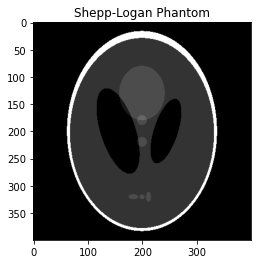

In [2]:
# create a simple shepp logan phantom and plot it
image = shepp_logan_phantom().astype(np.complex)
im_size = image.shape
plt.imshow(np.absolute(image))
plt.gray()
plt.title('Shepp-Logan Phantom')
plt.show()

In [3]:
# convert the phantom to a tensor and unsqueeze coil and batch dimension
image = torch.tensor(image, dtype=complex_dtype).unsqueeze(0).unsqueeze(0)
print('image shape: {}'.format(image.shape))

image shape: torch.Size([1, 1, 400, 400])


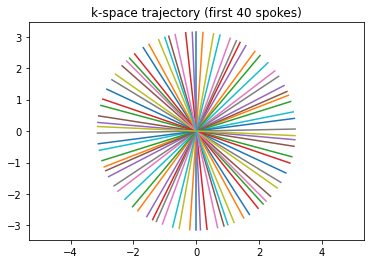

In [4]:
# create a k-space trajectory and plot it
spokelength = image.shape[-1] * 2
grid_size = (spokelength, spokelength)
nspokes = 405

ga = np.deg2rad(180 / ((1 + np.sqrt(5)) / 2))
kx = np.zeros(shape=(spokelength, nspokes))
ky = np.zeros(shape=(spokelength, nspokes))
ky[:, 0] = np.linspace(-np.pi, np.pi, spokelength)
for i in range(1, nspokes):
    kx[:, i] = np.cos(ga) * kx[:, i - 1] - np.sin(ga) * ky[:, i - 1]
    ky[:, i] = np.sin(ga) * kx[:, i - 1] + np.cos(ga) * ky[:, i - 1]
    
ky = np.transpose(ky)
kx = np.transpose(kx)

ktraj = np.stack((ky.flatten(), kx.flatten()), axis=0)

# plot the first 40 spokes
plt.plot(kx[:40, :].transpose(), ky[:40, :].transpose())
plt.axis('equal')
plt.title('k-space trajectory (first 40 spokes)')
plt.show()

In [5]:
# convert k-space trajectory to a tensor
ktraj = torch.tensor(ktraj, dtype=real_dtype)
print('ktraj shape: {}'.format(ktraj.shape))

ktraj shape: torch.Size([2, 324000])


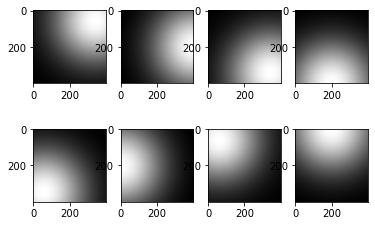

In [6]:
# simulate some sensitivity coils (no phase for simplicity)
ncoil = 8
smap = np.absolute(np.stack(mrisensesim(im_size, coil_width=64))).astype(np.complex)

fig, axs = plt.subplots(2, 4)
for i, ax in enumerate(axs.flat):
    ax.imshow(np.absolute(smap[i]))
plt.gray()
    
plt.show()

In [7]:
# convert smaps to tensors, unsqueeze batch dimension
smap = torch.tensor(smap, dtype=complex_dtype).unsqueeze(0)

In [8]:
# build nufft operators
nufft_ob = tkbn.KbNufft(im_size=im_size, grid_size=grid_size).to(image)
adjnufft_ob = tkbn.KbNufftAdjoint(im_size=im_size, grid_size=grid_size).to(image)
toep_ob = tkbn.ToepNufft()

dcomp = tkbn.calc_density_compensation_function(ktraj=ktraj, im_size=im_size)

print(nufft_ob)
print(adjnufft_ob)
print(toep_ob)


KbNufft
----------------------------------------
buffers
	tensor: table_0, shape: (6145,)
	tensor: table_1, shape: (6145,)
	tensor: im_size, shape: (2,)
	tensor: grid_size, shape: (2,)
	tensor: n_shift, shape: (2,)
	tensor: numpoints, shape: (2,)
	tensor: offsets, shape: (36, 2)
	tensor: table_oversamp, shape: (2,)
	tensor: order, shape: (2,)
	tensor: alpha, shape: (2,)
	tensor: scaling_coef, shape: (400, 400)


KbNufftAdjoint
----------------------------------------
buffers
	tensor: table_0, shape: (6145,)
	tensor: table_1, shape: (6145,)
	tensor: im_size, shape: (2,)
	tensor: grid_size, shape: (2,)
	tensor: n_shift, shape: (2,)
	tensor: numpoints, shape: (2,)
	tensor: offsets, shape: (36, 2)
	tensor: table_oversamp, shape: (2,)
	tensor: order, shape: (2,)
	tensor: alpha, shape: (2,)
	tensor: scaling_coef, shape: (400, 400)

ToepNufft()


In [9]:
# calculate the Toeplitz kernel with and without density compensation
normal_kernel = tkbn.calc_toeplitz_kernel(ktraj, im_size)  # without density compensation
dcomp_kernel = tkbn.calc_toeplitz_kernel(ktraj, im_size, weights=dcomp)  # with density compensation

In [10]:
# run a forward/backward the normal way without dcomp
start_normal_blurry = time.perf_counter()
image_blurry = adjnufft_ob(
    nufft_ob(image, ktraj, smaps=smap),
    ktraj,
    smaps=smap,
)
end_normal_blurry = time.perf_counter()

# run a forward/backward the normal way with dcomp
start_normal_sharp = time.perf_counter()
image_sharp = adjnufft_ob(
    dcomp * nufft_ob(image, ktraj, smaps=smap),
    ktraj,
    smaps=smap,
)
end_normal_sharp = time.perf_counter()

# run a forward/backward with Toeplitz without dcomp
start_toep_blurry = time.perf_counter()
image_blurry_toep = toep_ob(image, normal_kernel, smaps=smap)
end_toep_blurry = time.perf_counter()

# run a forward/backward with Toeplitz with dcomp
start_toep_sharp = time.perf_counter()
image_sharp_toep = toep_ob(image, dcomp_kernel, smaps=smap)
end_toep_sharp = time.perf_counter()

In [11]:
# print the timings and normalized differences
# blurry (no density compensation)
print('forward/backward without dcomp, normal time: {}, toeplitz time: {}'.format(
    end_normal_blurry-start_normal_blurry, end_toep_blurry-start_toep_blurry))
normdiff_blurry = (
    torch.norm(torch.abs(image_blurry-image_blurry_toep)) / 
    torch.norm(torch.abs(image_blurry))
)
print('normalized difference: {}'.format(normdiff_blurry))

# sharp (with density compensation)
print('forward/backward with dcomp, normal time: {}, toeplitz time: {}'.format(
    end_normal_sharp-start_normal_sharp, end_toep_sharp-start_toep_sharp))
normdiff_sharp = (
    torch.norm(torch.abs(image_sharp-image_sharp_toep)) / 
    torch.norm(torch.abs(image_sharp))
)
print('normalized difference: {}'.format(normdiff_sharp))

forward/backward without dcomp, normal time: 0.7766263596713543, toeplitz time: 0.04096749611198902
normalized difference: 2.4480716547259362e-06
forward/backward with dcomp, normal time: 0.6537928958423436, toeplitz time: 0.03831937117502093
normalized difference: 4.892172910331283e-06


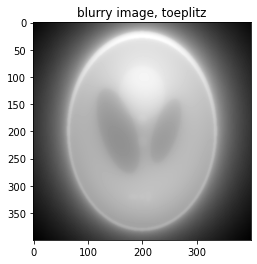

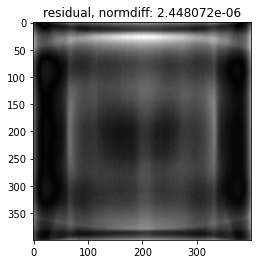

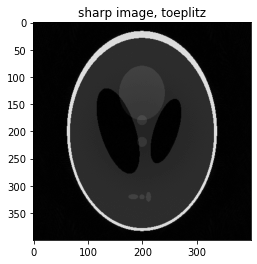

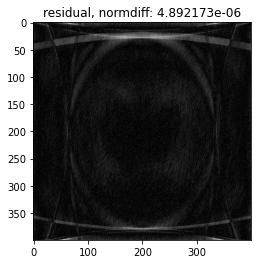

In [12]:
# show the images from the toeplitz results with residuals to normal
image_blurry_numpy = np.squeeze(image_blurry.numpy())

image_sharp_numpy = np.squeeze(image_sharp.numpy())

image_blurry_numpy_toep = np.squeeze(image_blurry_toep.numpy())

image_sharp_numpy_toep = np.squeeze(image_sharp_toep.numpy())

plt.figure(0)
plt.imshow(np.absolute(image_blurry_numpy_toep))
plt.gray()
plt.title('blurry image, toeplitz')

plt.figure(1)
plt.imshow(np.absolute(image_blurry_numpy_toep - image_blurry_numpy))
plt.gray()
plt.title('residual, normdiff: {:.6e}'.format(normdiff_blurry))

plt.figure(2)
plt.imshow(np.absolute(image_sharp_numpy_toep))
plt.gray()
plt.title('sharp image, toeplitz')

plt.figure(3)
plt.imshow(np.absolute(image_sharp_numpy_toep - image_sharp_numpy))
plt.gray()
plt.title('residual, normdiff: {:.6e}'.format(normdiff_sharp))

plt.show()